In [86]:
import numpy as np
import tensorflow as tf
import keras as k
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, TimeDistributed, LSTM
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import h5py
from keras.models import load_model
from keras.callbacks import EarlyStopping

#### Load and prepare data

In [76]:
with open('chess2040k_3060data', 'rb') as file:
    data1 = pickle.load(file)
with open('chess4570k_3060data', 'rb') as file:
    data2 = pickle.load(file)
with open('chess7k_3060data', 'rb') as file:
    data3 = pickle.load(file)  
with open('chess10k_3060data', 'rb') as file:
    data4 = pickle.load(file) 
data=np.concatenate((data1,data2, data3, data4))
print(data.shape)

(60000, 30, 12, 8, 8)


In [75]:
with open('chess2040k_3060labels', 'rb') as file:
    labels1 = pickle.load(file)
with open('chess4570k_3060labels', 'rb') as file:
    labels2 = pickle.load(file)
with open('chess7k_3060labels', 'rb') as file:
    labels3 = pickle.load(file)
with open('chess10k_3060labels', 'rb') as file:
    labels4 = pickle.load(file) 
labels=np.concatenate((labels1.values, labels2.values, labels3.values, labels4.values))              
print(labels.shape)

(60000,)


In [77]:
'''center data around 0 by subtracting mean. Could also divide by standard dev but values are just 1s and 0s
so the scale is ok. Then split in train and test, here 80/20 '''

data=data-np.mean(data)
n_split=int(len(data)*8/10)
x_train=data[:n_split]
y_train=labels[:n_split]
x_test=data[n_split:]
y_test=labels[n_split:]
num_classes=2
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)
(img_rows, img_cols, channels)=(8,8,12)

In [78]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Set hyperparameters and build model.
The initial chess area is 8 x 8 , so we will just use the default of not using padding in our convolutional net. This will reduce the size to 6 x 6 in the first step, 4 x 4 in the next, and finally 2 x 2. THERE WILL BE NO POOLING!!! pooling is useful when it doesn't matter whether a feature is detected on one pixel or the next to it. In chess it matters! the Queen beeing on one or the other field is the difference between a checkmate and a lost game....
 

In [98]:
num_filters=20
kernel_size=(3,3)
ac='relu'
opt=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
drop=0.5
reg=None
#reg=l2(0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


model = Sequential()

model.add(TimeDistributed(
    Conv2D(num_filters, kernel_size, activation=ac, input_shape=(12, 8, 8), kernel_regularizer=reg, 
           data_format="channels_first"), input_shape=(30, 12, 8, 8))
         )
model.add(BatchNormalization(axis=-1))
model.add(TimeDistributed(Conv2D(2*num_filters, kernel_size, activation=ac,
                                 kernel_regularizer=reg, data_format="channels_first")))
model.add(BatchNormalization(axis=-1))
model.add(TimeDistributed(Conv2D(4*num_filters, kernel_size, activation=ac,
                                 kernel_regularizer=reg, data_format="channels_first")))
model.add(BatchNormalization(axis=-1))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(80))
model.add(Dropout(drop))
model.add(Dense(30))
model.add(Dropout(drop))
model.add(Dense(num_classes, activation='softmax'))
          
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [99]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_89 (TimeDis (None, 30, 20, 6, 6)      2180      
_________________________________________________________________
batch_normalization_67 (Batc (None, 30, 20, 6, 6)      24        
_________________________________________________________________
time_distributed_90 (TimeDis (None, 30, 40, 4, 4)      7240      
_________________________________________________________________
batch_normalization_68 (Batc (None, 30, 40, 4, 4)      16        
_________________________________________________________________
time_distributed_91 (TimeDis (None, 30, 80, 2, 2)      28880     
_________________________________________________________________
batch_normalization_69 (Batc (None, 30, 80, 2, 2)      8         
_________________________________________________________________
time_distributed_92 (TimeDis (None, 30, 320)           0         
__________

In [100]:
history1=model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test),
                   callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 67s 1ms/step - loss: 0.6765 - acc: 0.5964 - val_loss: 0.6556 - val_acc: 0.5948
Epoch 2/10
48000/48000 [==============================] - 70s 1ms/step - loss: 0.5586 - acc: 0.7215 - val_loss: 0.5077 - val_acc: 0.7470
Epoch 3/10
48000/48000 [==============================] - 69s 1ms/step - loss: 0.4951 - acc: 0.7673 - val_loss: 0.4680 - val_acc: 0.7722
Epoch 4/10
48000/48000 [==============================] - 69s 1ms/step - loss: 0.4519 - acc: 0.7920 - val_loss: 0.4592 - val_acc: 0.7816
Epoch 5/10
48000/48000 [==============================] - 70s 1ms/step - loss: 0.4145 - acc: 0.8129 - val_loss: 0.4562 - val_acc: 0.7860
Epoch 6/10
48000/48000 [==============================] - 69s 1ms/step - loss: 0.3839 - acc: 0.8296 - val_loss: 0.4453 - val_acc: 0.7907
Epoch 7/10
48000/48000 [==============================] - 70s 1ms/step - loss: 0.3498 - acc: 0.8488 - val_loss: 0.4519 - val_acc

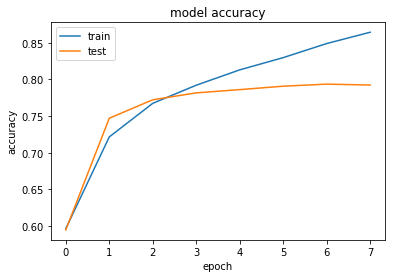

In [101]:
plothist(history1) #drop 0.5, filters 20, LSTM,Dense 80/30, lr 0.001

In [92]:
history2=model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test),
                  callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 66s 1ms/step - loss: 0.6755 - acc: 0.5834 - val_loss: 0.6936 - val_acc: 0.5228
Epoch 2/20
48000/48000 [==============================] - 69s 1ms/step - loss: 0.5700 - acc: 0.7091 - val_loss: 0.5121 - val_acc: 0.7451
Epoch 3/20
48000/48000 [==============================] - 69s 1ms/step - loss: 0.5064 - acc: 0.7584 - val_loss: 0.4816 - val_acc: 0.7655
Epoch 4/20
48000/48000 [==============================] - 70s 1ms/step - loss: 0.4629 - acc: 0.7862 - val_loss: 0.4577 - val_acc: 0.7807
Epoch 5/20
48000/48000 [==============================] - 71s 1ms/step - loss: 0.4284 - acc: 0.8057 - val_loss: 0.4647 - val_acc: 0.7874
Epoch 6/20
48000/48000 [==============================] - 72s 2ms/step - loss: 0.3965 - acc: 0.8219 - val_loss: 0.4529 - val_acc: 0.7917
Epoch 7/20
48000/48000 [==============================] - 70s 1ms/step - loss: 0.3646 - acc: 0.8410 - val_loss: 0.4470 - val_acc

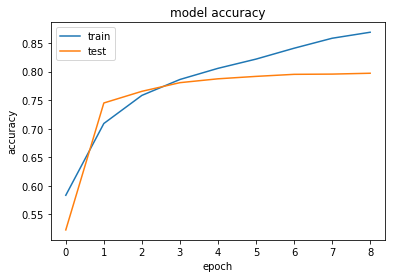

In [93]:
plothist(history2)  # drop 0.5, filters 20, LSTM,Dense 50, lr 0.001

In [90]:
#model.save('chess_82percent.h5')